In [1]:
import numpy as np
import torch 
import scipy.stats
import math
from scipy.stats import multivariate_normal
from torch import distributions
import pymc3 as pm
import random
import seaborn as sns

In [2]:
#pip install pymc3
#pip install numpy --upgrade
OMP_NUM_THREADS=20
openmp=True

## Model 1
$\ Z_{it}|Z_{i,t-1}$ ~ $\ N$($\Omega Z_{i,t-1}$, $\ I$\)\
$\ X_{it}|Z_{i,t}$ ~ $\ N$($\ Z_{i,t}$, $\ I$\)

Theoretical derivation gives:\
$\ Z_{it}|X_{i,t}$ ~ $\ N$($(1/2)*(\Omega Z_{i,t-1} + \ X_{i,t})$, $\ I/2$\)


In [3]:
N = 50 # num patients
T = 10 # num of hospital visits for each patients
random.seed(53)
zdim = 10
xdim = zdim

Z = torch.zeros((N, T, zdim)) # latent
logPZ = torch.zeros((N, T)) 
X = torch.zeros((N, T, xdim)) # observed
PX = torch.zeros((N, T, xdim)) 
logPX = torch.zeros((N, T))
d = torch.ones(zdim,requires_grad = True) 
omega = torch.diag(d) # should be invertible
Psi = torch.ones((xdim,zdim),requires_grad = True) # should be full rank , xdim > zdim


for t in range(1,T):
    # Zit|Zi,t-1
    meanz = torch.matmul(Z[:,t-1], omega)
    cov = torch.eye(zdim)
    Zt = torch.distributions.multivariate_normal.MultivariateNormal(meanz, cov)
    Z[:,t] = Zt.sample()
    logPZ[:,t] = Zt.log_prob(Z[:,t])


    #Xit|Zit
    meanx = Z[:,t] 
    cov = torch.eye(xdim) 
    Xt = torch.distributions.multivariate_normal.MultivariateNormal(meanx, cov)
    X[:,t] = Xt.sample()
    logPX[:,t] = Xt.log_prob(X[:,t])


        
        
def posterior_i(x,omega):
    n,t,xdim = x.size()
    zdim = xdim
    z = torch.zeros((n,t,zdim))
    logpz = torch.zeros((n, t)) 

    for j in range(1,t):     
        mean = 1/2*(torch.matmul(Z[:,j-1], omega) + x[:,j])
        cov = torch.eye(zdim)*(1/2)
        zt = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
        z[:,j] = zt.sample()
        logpz[:,j] = zt.log_prob(z[:,j])     
    return z, logpz
        

    
Z_posterior = torch.zeros((N, T, zdim))
Z_posterior,log_posterior = posterior_i(X,omega)

In [4]:
torch.mean((Z-Z_posterior)**2)

tensor(0.8897)

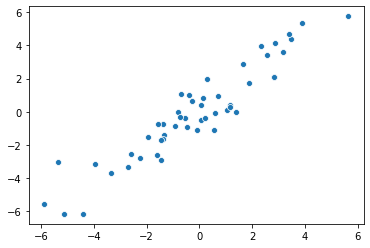

In [5]:
sns.scatterplot(Z_posterior[:,T-1,0],Z[:,T-1,0])

## Model 2

$\ Z_{it}|Z_{i,t-1}$ ~ $\ N$($\Omega Z_{i,t-1}$, $\ I$\)\
$\ X_{it}|Z_{i,t}$ ~ $\ N$($\Psi Z_{i,t}$, $\ I$\)

Theoretical derivation gives:\
$\ Z_{it}|X_{i,t}$ ~ $\ N$($(I + \Psi^T \Psi)^{-1}*(\Omega Z_{i,t-1} + \Psi^{T} X_{i,t})$, $(I + \Psi^T \Psi)^{-1}\$)


### Testing cases

In [6]:
def posterior_i2(x,omega,psi,zdim):
    n,t,xdim = x.size()
    z = torch.zeros((n,t,zdim))
    logpz = torch.zeros((n, t)) 
    I_psi = torch.eye(zdim) + torch.matmul(psi.t(),psi)
    inverse = I_psi.inverse()
    
    
    for j in range(1,t):     
#        print(z[:,j-1].size(), omega.size())
#        print(x[:,j].size(), psi.t().size())

        mean2 = torch.matmul(z[:,j-1], omega) + torch.matmul(x[:,j],psi)
        mean = torch.matmul(mean2,inverse)
        zt = torch.distributions.multivariate_normal.MultivariateNormal(mean, inverse)
        z[:,j] = zt.sample()
        logpz[:,j] = zt.log_prob(z[:,j])     
    return z, logpz
        

In [7]:
def testing_psi1(N,T,zdim,xdim,cov_scale):
    Z = torch.zeros((N, T, zdim)) # latent
    logPZ = torch.zeros((N, T)) 
    X = torch.zeros((N, T, xdim)) # observed
    PX = torch.zeros((N, T, xdim)) 
    logPX = torch.zeros((N, T))
    d = torch.ones(zdim,requires_grad = True) 
    omega = torch.diag(d) # should be invertible
    Psi = torch.ones((xdim,zdim),requires_grad = True) # should be full rank , xdim > zdim


    for t in range(1,T):
        # Zit|Zi,t-1
        meanz = torch.matmul(Z[:,t-1], omega)
        cov = torch.eye(zdim)
        Zt = torch.distributions.multivariate_normal.MultivariateNormal(meanz, cov)
        Z[:,t] = Zt.sample()
        logPZ[:,t] = Zt.log_prob(Z[:,t])


        #Xit|Zit
        meanx = torch.matmul(Z[:,t], Psi.t())
        cov = torch.eye(xdim)*cov_scale
        Xt = torch.distributions.multivariate_normal.MultivariateNormal(meanx, cov)
        X[:,t] = Xt.sample()
        logPX[:,t] = Xt.log_prob(X[:,t])


    Z_posterior = torch.zeros((N, T, zdim))
    Z_posterior,log_posterior = posterior_i2(X,omega,Psi,zdim)
    return Z, X, Z_posterior, log_posterior

### 1. T = 1, xdim = zdim = 1, Psi = 1, cov(X|Z) = I*(1e-3)

Text(0.5, 1.0, 'simulated x vs simulated z')

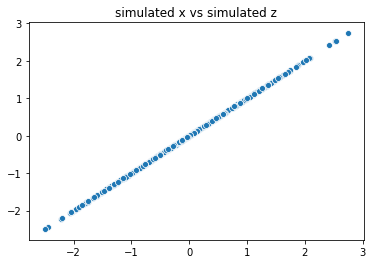

In [8]:
N = 500 # num patients
T = 2 # num of hospital visits for each patients
zdim = 1
xdim = zdim

random.seed(53)
Z1,X1, Z_posterior1, log_posterior1 = testing_psi1(N,T,zdim,xdim,1e-9)
test1_1 = sns.scatterplot(Z1[:,T-1,0],X1[:,T-1,0])
test1_1.set_title('simulated x vs simulated z')

Text(0.5, 1.0, 'simulated z vs posterior z')

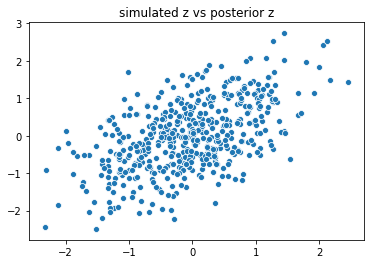

In [9]:
test1_2 = sns.scatterplot(Z_posterior1[:,T-1,0],Z1[:,T-1,0])
test1_2.set_title('simulated z vs posterior z')

Text(0.5, 1.0, 'simulated x vs posterior z')

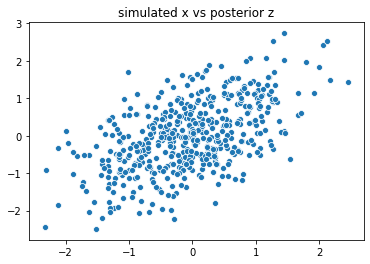

In [10]:
test1_3 = sns.scatterplot(Z_posterior1[:,T-1,0],X1[:,T-1,0])
test1_3.set_title('simulated x vs posterior z')

### 2. T = 1, xdim = zdim = 1, Psi = 1, cov(X|Z) = I*(1e+3)


Text(0.5, 1.0, 'simulated x vs simulated z')

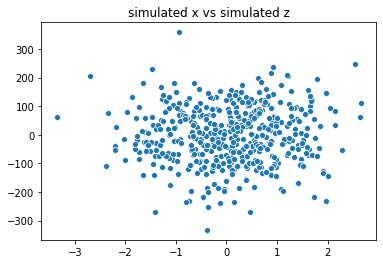

In [11]:
N = 500 # num patients
T = 2 # num of hospital visits for each patients
zdim = 1
xdim = zdim
random.seed(53)
Z2,X2, Z_posterior2, log_posterior2 = testing_psi1(N,T,zdim,xdim,1e+4)
test2_1 = sns.scatterplot(Z2[:,T-1,0],X2[:,T-1,0])
test2_1.set_title('simulated x vs simulated z')

Text(0.5, 1.0, 'simulated z vs posterior z')

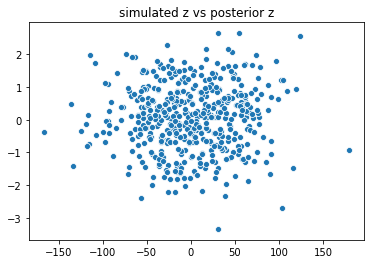

In [12]:
test2_2 = sns.scatterplot(Z_posterior2[:,T-1,0],Z2[:,T-1,0])
test2_2.set_title('simulated z vs posterior z')

Text(0.5, 1.0, 'simulated x vs posterior z')

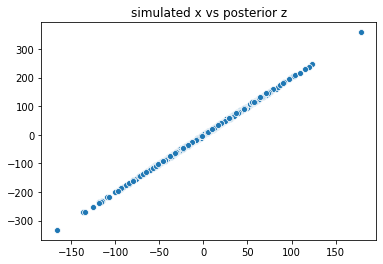

In [13]:
test2_3 = sns.scatterplot(Z_posterior2[:,T-1,0],X2[:,T-1,0])
test2_3.set_title('simulated x vs posterior z')

### 3. xdim = 1000  zdim = 2, Psi = 1, cov(X|Z) = I


Text(0.5, 1.0, 'simulated x vs simulated z')

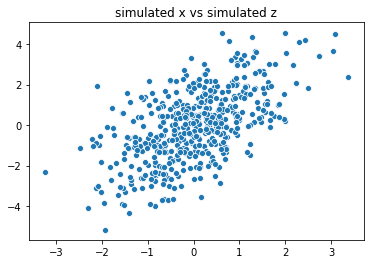

In [14]:
N = 500 # num patients
T = 2 # num of hospital visits for each patients
zdim = 2
xdim = 1000
random.seed(53)
Z3,X3, Z_posterior3, log_posterior3 = testing_psi1(N,T,zdim,xdim,1)
test3_1 = sns.scatterplot(Z3[:,T-1,0],X3[:,T-1,0])
test3_1.set_title('simulated x vs simulated z')

Text(0.5, 1.0, 'simulated z vs posterior z')

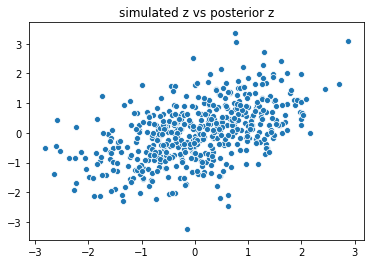

In [15]:
test3_2 = sns.scatterplot(Z_posterior3[:,T-1,0],Z3[:,T-1,0])
test3_2.set_title('simulated z vs posterior z')

Text(0.5, 1.0, 'simulated x vs posterior z')

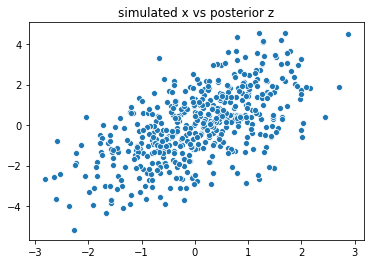

In [16]:
test3_3 = sns.scatterplot(Z_posterior3[:,T-1,0],X3[:,T-1,0])
test3_3.set_title('simulated x vs posterior z')

### 4. xdim = 1  zdim = 1, Psi = 1, cov(X|Z) = I


Text(0.5, 1.0, 'simulated x vs simulated z')

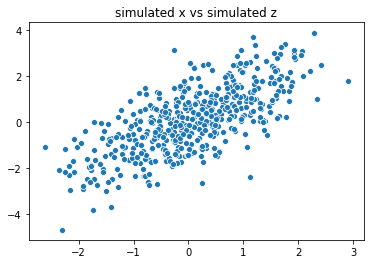

In [17]:
N = 500 # num patients
T = 2 # num of hospital visits for each patients
zdim = 1
xdim = 1
random.seed(53)
Z4,X4, Z_posterior4, log_posterior4 = testing_psi1(N,T,zdim,xdim,1)
test4_1 = sns.scatterplot(Z4[:,T-1,0],X4[:,T-1,0])
test4_1.set_title('simulated x vs simulated z')

Text(0.5, 1.0, 'simulated z vs posterior z')

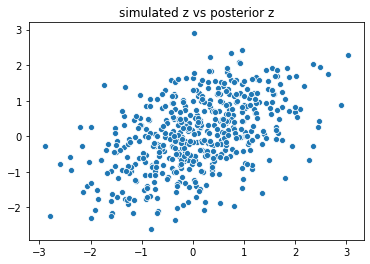

In [18]:
test4_2 = sns.scatterplot(Z_posterior4[:,T-1,0],Z4[:,T-1,0])
test4_2.set_title('simulated z vs posterior z')

Text(0.5, 1.0, 'simulated x vs posterior z')

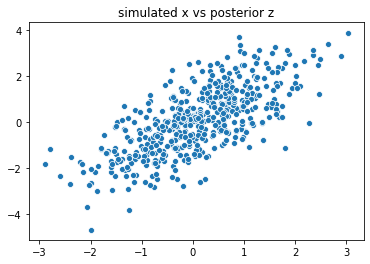

In [19]:
test4_3 = sns.scatterplot(Z_posterior4[:,T-1,0],X4[:,T-1,0])
test4_3.set_title('simulated x vs posterior z')

### 5. xdim = 1 zdim = 1, Psi = 0, cov(X|Z) = I


In [20]:
def testing_psi0(N,T,zdim,xdim,cov_scale):
    Z = torch.zeros((N, T, zdim)) # latent
    logPZ = torch.zeros((N, T)) 
    X = torch.zeros((N, T, xdim)) # observed
    PX = torch.zeros((N, T, xdim)) 
    logPX = torch.zeros((N, T))
    d = torch.ones(zdim,requires_grad = True) 
    omega = torch.diag(d) # should be invertible
    Psi = torch.zeros((xdim,zdim),requires_grad = True) # should be full rank , xdim > zdim


    for t in range(1,T):
        # Zit|Zi,t-1
        meanz = torch.matmul(Z[:,t-1], omega)
        cov = torch.eye(zdim)
        Zt = torch.distributions.multivariate_normal.MultivariateNormal(meanz, cov)
        Z[:,t] = Zt.sample()
        logPZ[:,t] = Zt.log_prob(Z[:,t])


        #Xit|Zit
        meanx = torch.matmul(Z[:,t], Psi.t())
        cov = torch.eye(xdim)*cov_scale
        Xt = torch.distributions.multivariate_normal.MultivariateNormal(meanx, cov)
        X[:,t] = Xt.sample()
        logPX[:,t] = Xt.log_prob(X[:,t])


    Z_posterior = torch.zeros((N, T, zdim))
    Z_posterior,log_posterior = posterior_i2(X,omega,Psi,zdim)
    return Z, X, Z_posterior, log_posterior

Text(0.5, 1.0, 'simulated x vs simulated z')

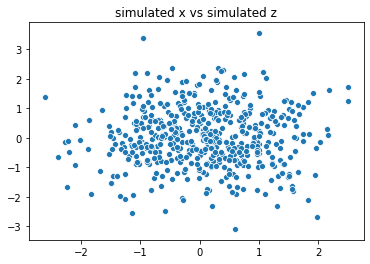

In [21]:
N = 500 # num patients
T = 2 # num of hospital visits for each patients
zdim = 1
xdim = 1
random.seed(53)
Z5,X5, Z_posterior5, log_posterior5 = testing_psi0(N,T,zdim,xdim,1)
test5_1 = sns.scatterplot(Z5[:,T-1,0],X5[:,T-1,0])
test5_1.set_title('simulated x vs simulated z')

Text(0.5, 1.0, 'simulated z vs posterior z')

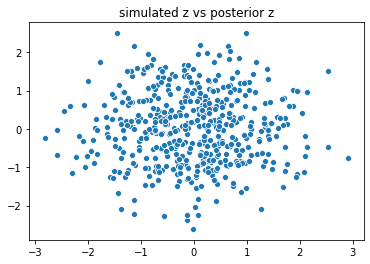

In [22]:
test5_2 = sns.scatterplot(Z_posterior5[:,T-1,0],Z5[:,T-1,0])
test5_2.set_title('simulated z vs posterior z')

Text(0.5, 1.0, 'simulated x vs posterior z')

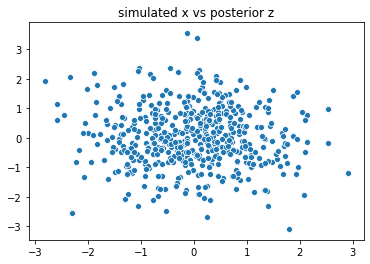

In [23]:
test5_3 = sns.scatterplot(Z_posterior5[:,T-1,0],X5[:,T-1,0])
test5_3.set_title('simulated x vs posterior z')